### Some imports

In [38]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [39]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")

In [40]:
tsla_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## PART I

In [41]:
# Load Tesla stock data
tesla_data = tsla_df

# Ensure Date is the index
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

# Sort data by date
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

# Use 'Close' price for prediction
data = tesla_data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data to fit LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [42]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6130e-04 - val_loss: 0.0023
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7325e-06 - val_loss: 0.0019
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.5746e-06 - val_loss: 0.0016
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.3037e-06 - val_loss: 0.0022
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.1977e-06 - val_loss: 0.0014
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.1483e-06 - val_loss: 0.0012
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.2172e-06 - val_loss: 0.0012
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9837e-06 - val_loss: 0.0013
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2934e-06 - val_loss: 0.0014
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.0403e-06 - val_loss: 0.0013


In [43]:
# Predict and inverse transform the scaled data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f'RMSE: {rmse}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 43.39722554999334


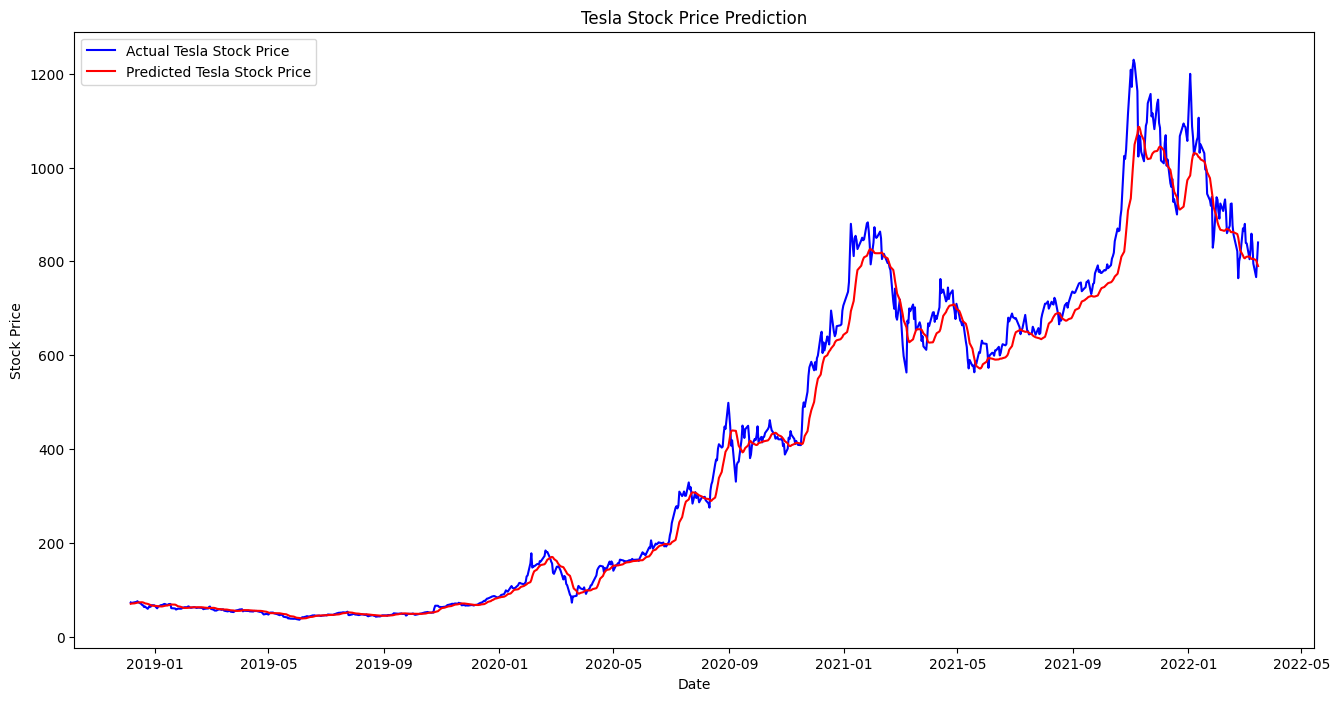

In [44]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [45]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])


# Merge Tesla and gold data on date
combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = combined[['Date', 'Volume_x', 'Volume_y']]

# Normalize combined data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data[['Volume_x', 'Volume_y']])

In [46]:
# Prepare the dataset for LSTM
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(Y)

In [47]:
X, Y = create_dataset_with_gold(scaled_data, seq_length)

# Split the data into training and testing sets (70% training, 30% testing)
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [48]:
# Define the LSTM model
model_comb = Sequential()
model_comb.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_comb.add(LSTM(50, return_sequences=False))
model_comb.add(Dense(25))
model_comb.add(Dense(1))

# Compile the model
model_comb.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
# Train the model
history_comb = model_comb.fit(X_train, Y_train, batch_size=32, epochs=10)
# history_comb = model_comb.fit(X_train_comb, y_train_comb, epochs=10, batch_size=32, validation_data=(X_test_comb, y_test_comb))

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.5650e-04
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.8084e-06
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2826e-06
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5577e-06
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7057e-06
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.2728e-06
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3090e-06
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6494e-06
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3240e-06
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0508e-06


In [50]:
train_predict = model_comb.predict(X_train)
test_predict = model_comb.predict(X_test)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [51]:
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)

train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print(f'Train MAE (with gold): {train_mae}, Train RMSE (with gold): {train_rmse}')
print(f'Test MAE (with gold): {test_mae}, Test RMSE (with gold): {test_rmse}')

Train MAE (with gold): 0.0012147146133819906, Train RMSE (with gold): 0.001824305419618228
Test MAE (with gold): 0.024866946947383735, Test RMSE (with gold): 0.0434394523455997


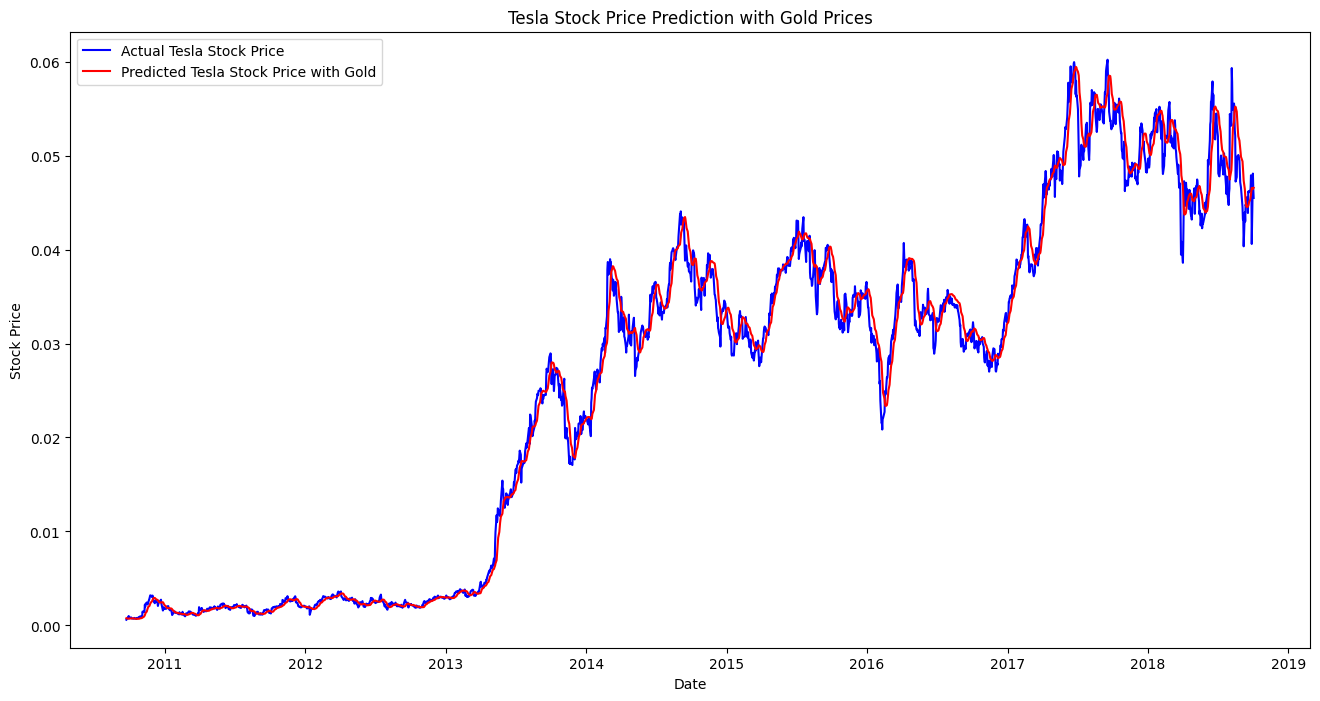

In [52]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], Y_train, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], train_predict, color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()